Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Análise de componentes principais (PCA) e análise de discriminantes lineares (LDA)

Neste exercício, você vai trabalhar com uma aplicação de redes neurais para  para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.

## Dados disponibilizados

Os dados para treinamento e teste do modelo estão disponíveis no formato CSV, em um arquivo zip disponível [neste link](./data.zip).

Após extrair os arquivos, utiliza a biblioteca Pandas para carregar os `DataFrames` `data_train` e `data_test`, como mostrado a seguir:

``` python
import pandas as pd

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])

data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])
```

Os dados consistem de 800 exemplos de treinamento e 225 para teste, cada um contendo 13 características de entrada, representadas pelas colunas de 0 a 12 e a saída desejada binária, indicando se o paciente é portador ou não da doença, representada pela coluna 13.

O objetivo é treinar uma rede neural com estes dados, avaliar o desempenho e depois comparar com o desempenho obtido usando o PCA para realizar redução de dimensionalidade. Use como referência o exemplo mostrado [neste Jupyter Notebook](./PCA_IRIS.ipynb)

# Exercício 1

Implemente uma rede neural para classificar se o indivíduo é portador ou não da doença cardíaca (coluna 13) usando como entrada os dados dos exames laboratoriais (colunas 1 a 12). Calcule a acurácia obtida nos dados de teste.

## Resolução

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Carregamento dos dados

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

In [3]:
data_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,62.0,1.0,1.0,128.0,208.0,1.0,0.0,140.0,0.0,0.0,2.0,0.0,2.0,1.0
796,41.0,1.0,1.0,135.0,203.0,0.0,1.0,132.0,0.0,0.0,1.0,0.0,1.0,1.0
797,65.0,0.0,0.0,150.0,225.0,0.0,0.0,114.0,0.0,1.0,1.0,3.0,3.0,0.0
798,59.0,1.0,3.0,170.0,288.0,0.0,0.0,159.0,0.0,0.2,1.0,0.0,3.0,0.0


In [4]:
n_total = len(data_train)
n_treino = int(n_total * 0.8) # Divisão 80/20 (treino/validação)

indices_aleatorios = np.random.permutation(n_total)

indices_treino = indices_aleatorios[:n_treino]
indices_val = indices_aleatorios[n_treino:]

# DataFrames de treino e validação
df_treino = data_train.iloc[indices_treino]
df_val = data_train.iloc[indices_val]

print(len(df_treino))
print(len(df_val))

# Dados de treino
x_treino_np = df_treino.iloc[:, :-1].to_numpy()
d_treino_np = df_treino.iloc[:, -1].to_numpy()

# Dados de validação
x_val_np = df_val.iloc[:, :-1].to_numpy()
d_val_np = df_val.iloc[:, -1].to_numpy()

# ============================================================== #
# Normalizar os dados de treino e val

# Calcula a média das características
media_treino = np.mean(x_treino_np, axis=0)

# Calcula o desvio padrao das características
desvio_padrao_treino = np.std(x_treino_np, axis=0, ddof=1)

# Aplica a normalização no conjunto
x_treino_np_norm = (x_treino_np - media_treino) / desvio_padrao_treino
x_val_np_norm = (x_val_np - media_treino) / desvio_padrao_treino

# ============================================================== #
# Converter para tensores PyTorch
x_treino_tensor = torch.tensor(x_treino_np_norm, dtype=torch.float32)
d_treino_tensor = torch.tensor(d_treino_np, dtype=torch.long)

x_val_tensor = torch.tensor(x_val_np_norm, dtype=torch.float32)
d_val_tensor = torch.tensor(d_val_np, dtype=torch.long)

# print(f"x_treino: {x_treino_np.shape}")
# print(f"d_treino: {d_treino_np.shape}")
# print(f"x_val: {x_val_np.shape}")
# print(f"d_val: {d_val_np.shape}")

640
160


In [5]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(13, 8),
        nn.ReLU(),

        nn.Linear(8, 4),
        nn.ReLU(),

        nn.Linear(4, 4),
        nn.ReLU(),

        nn.Linear(4, 2),
    )

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        # Inicializa os bias com zero
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    output = self.model(x)
    return output

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device=device)

# Taxa de aprendizado
eta = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta)

Nb = 64 # Tamanho do mini-batch
Ne = 1000 # Número de épocas


In [7]:

train_set = TensorDataset(x_treino_tensor, d_treino_tensor)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

Epoch: 0 | Loss: 1.1117432117462158 | Val. Loss: 1.006931185722351
Epoch: 1 | Loss: 0.874767005443573 | Val. Loss: 0.9091665148735046
Epoch: 2 | Loss: 0.8718933463096619 | Val. Loss: 0.8369107246398926
Epoch: 3 | Loss: 0.7873045802116394 | Val. Loss: 0.7852379083633423
Epoch: 4 | Loss: 0.7184702157974243 | Val. Loss: 0.7457254528999329
Epoch: 5 | Loss: 0.8258110880851746 | Val. Loss: 0.7148048281669617
Epoch: 6 | Loss: 0.7319589257240295 | Val. Loss: 0.689213216304779
Epoch: 7 | Loss: 0.6962003111839294 | Val. Loss: 0.6667453646659851
Epoch: 8 | Loss: 0.6762041449546814 | Val. Loss: 0.6464430093765259
Epoch: 9 | Loss: 0.5536878108978271 | Val. Loss: 0.6263147592544556
Epoch: 10 | Loss: 0.5572153925895691 | Val. Loss: 0.6067589521408081
Epoch: 11 | Loss: 0.6220384836196899 | Val. Loss: 0.5894861221313477
Epoch: 12 | Loss: 0.5398086905479431 | Val. Loss: 0.5755870938301086
Epoch: 13 | Loss: 0.5239238739013672 | Val. Loss: 0.5618473291397095
Epoch: 14 | Loss: 0.5003175139427185 | Val. Los

Text(0, 0.5, 'Loss')

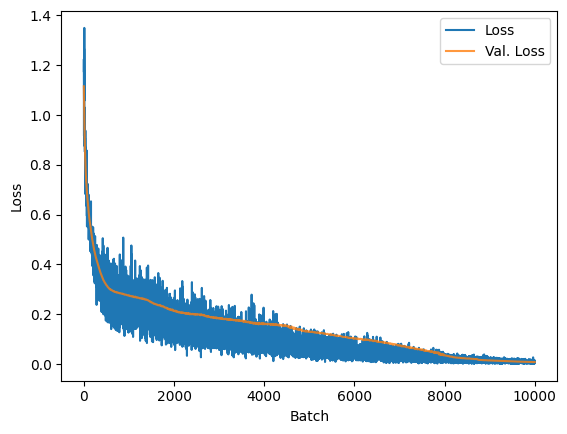

In [8]:
# Treinamento
losses = []
val_losses = []

x_val_tensor = x_val_tensor.to(device=device)
d_val_tensor = d_val_tensor.to(device=device)

for epoch in range(Ne):
  for n, (X, d) in enumerate(train_loader):

    X = X.to(device=device)
    d = d.to(device=device)

    # Treinamento
    model.train()
    model.zero_grad()
    y = model(X)
    loss = loss_function(y, d)
    loss.backward()
    optimizer.step()

    # Validação
    model.eval()

    with torch.no_grad():
      y_val = model(x_val_tensor)
      val_loss = loss_function(y_val, d_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 and n == x_treino_tensor.shape[0]//Nb - 1:
      print(f"Epoch: {epoch} | Loss: {loss} | Val. Loss: {val_loss}")

plt.figure()
plt.plot(losses)
plt.plot(val_losses, alpha=0.8)
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")


In [9]:
# Testando o modelo

# Converte os dados de teste em arrays numpy
x_teste_np = data_test.iloc[:, :-1].to_numpy()
d_teste_np = data_test.iloc[:, -1].to_numpy()

# Aplica a normalização no conjunto de teste
x_teste_np_norm = (x_teste_np - media_treino) / desvio_padrao_treino

# Converte os arrays numpy em tensores PyTorch
x_teste_tensor = torch.tensor(x_teste_np_norm, dtype=torch.float32).to(device=device)
d_teste_tensor = torch.tensor(d_teste_np, dtype=torch.long).to(device=device)

# Testa o modelo com os dados de teste
y_teste_tensor = model(x_teste_tensor)
y_teste_np = y_teste_tensor.cpu().detach().numpy()

predicoes = np.argmax(y_teste_np, axis=1)
acuracia = np.mean(predicoes == d_teste_np)

# Taxa de erros

Taxa_de_erro = (1 - acuracia) * 100

print(f"Acurácia: {acuracia*100:.2f}%")
print(f"Taxa de erro: {Taxa_de_erro:.2f}%")

Acurácia: 98.67%
Taxa de erro: 1.33%


In [10]:
data_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.0,3.0,0.0
1,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
2,63.0,0.0,0.0,124.0,197.0,0.0,1.0,136.0,1.0,0.0,1.0,0.0,2.0,0.0
3,52.0,1.0,0.0,112.0,230.0,0.0,1.0,160.0,0.0,0.0,2.0,1.0,2.0,0.0
4,58.0,0.0,0.0,130.0,197.0,0.0,1.0,131.0,0.0,0.6,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,59.0,1.0,1.0,140.0,221.0,0.0,1.0,164.0,1.0,0.0,2.0,0.0,2.0,1.0
221,60.0,1.0,0.0,125.0,258.0,0.0,0.0,141.0,1.0,2.8,1.0,1.0,3.0,0.0
222,47.0,1.0,0.0,110.0,275.0,0.0,0.0,118.0,1.0,1.0,1.0,1.0,2.0,0.0
223,50.0,0.0,0.0,110.0,254.0,0.0,0.0,159.0,0.0,0.0,2.0,0.0,2.0,1.0


# Exercício 2

Aplique o PCA nos dados de entrada e obtenha uma matriz de dados transformados representando os 12 componentes principais. Mostre o valor da porcentagem de variância explicada acumulada à medida que você considera um maior número de componentes principais.

## Resolução

In [33]:
# Vamos aplicar a PCA sobre os dados normalizados

# x_treino_np_norm
# d_treino_np
# x_val_np_norm
# d_val_np

# D: número de características
# N: número de exemplos
# M: número de características no espaço projetado

# P = UX (M X N)
# U = matriz com os autovetores da matriz de covariância dos dados (M X D)
# X = matriz com os dados normalizados (D X N)

X_treino = x_treino_np_norm.T
N_treino = X_treino.shape[1]

# Matriz de covariância dos dados de treino
S_treino = (X_treino @ X_treino.T) / N_treino # (D X D)

autovalores, autovetores = np.linalg.eig(S_treino)

# Ordenar os autovalores em ordem decrescente
indices_ordenados = np.argsort(autovalores)
indices_decrescente = indices_ordenados[::-1]

autovalores = autovalores[indices_decrescente]
autovetores = autovetores[:, indices_decrescente]

# Variância explicada
var_explicada = (autovalores / np.sum(autovalores)) * 100

# Variância acumulada
var_acumulada = np.cumsum(var_explicada)

print(f"{'M':<5} | {'Variância acumulada (%)'}")
print("-" * 30)

for i, variancia in enumerate(var_acumulada):
  M = i + 1
  print(f"{M:<5} | {variancia:.2f}%")


[2.86740774 1.46122368 1.25520296 1.15314482 1.04667089 0.9734824
 0.87201375 0.73645678 0.72308199 0.6074035  0.52547499 0.40691905
 0.35120494]
M     | Variância acumulada (%)
------------------------------
1     | 22.09%
2     | 33.35%
3     | 43.02%
4     | 51.90%
5     | 59.97%
6     | 67.47%
7     | 74.19%
8     | 79.86%
9     | 85.43%
10    | 90.11%
11    | 94.16%
12    | 97.29%
13    | 100.00%


In [38]:
# Projetar dados com M = 12 componentes principais

M = 12
U = autovetores[:, :M].T

# Transformação linear P = UX
P_treino = U @ X_treino
print("Matriz dos dados transformados no subespaço de dimensão M=12")
print(P_treino)

Matriz dos dados transformados no subespaço de dimensão M=12
[[-0.07935227 -0.89318144  0.69595694 ... -0.01517568  1.68807942
   3.03084608]
 [ 0.1416988   1.1531973   0.45705237 ...  0.04659808  1.32358092
  -0.11026535]
 [-1.61382313  2.04073754 -1.23264821 ...  0.00375707 -0.10833941
   0.55461342]
 ...
 [ 0.15169618  0.01428737  0.04966463 ... -0.51195944  0.17841599
   0.62290624]
 [-0.81245546 -1.61807682 -0.09708913 ...  0.77008586 -0.71805743
  -0.70736993]
 [ 1.17086285  0.39181812  0.25373326 ...  0.70881926 -0.42611976
  -0.59610936]]


# Exercício 3

Implemente uma segunda rede neural para fazer a classificação usando o número de componentes principais necessário para incluir 90% da variância explicada. Calcule a acurácia obtida nos dados de teste.

## Resolução

Como vimos na tabela do exercício 2, o número mínimo de componentes principais necessário para incluir 90% da variância explicada é M=10.

In [46]:
M = 10
U = autovetores[:, :M].T

# Transformação linear P = UX
P_treino = U @ X_treino

# Projetando também nos dados de validação
X_val = x_val_np_norm.T
P_val = U @ X_val

# Convertendo em tensores Pytorch
x_treino_pca = torch.tensor(P_treino.T, dtype=torch.float32)
x_val_pca = torch.tensor(P_val.T, dtype=torch.float32)

# Vou definir d_treino_tensor e d_val_tensor de novo mas é o mesmo
d_treino_tensor = torch.tensor(d_treino_np, dtype=torch.long)
d_val_tensor = torch.tensor(d_val_np, dtype=torch.long)

In [47]:
class ModelPCA(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(10, 8),
        nn.ReLU(),

        nn.Linear(8, 4),
        nn.ReLU(),

        nn.Linear(4, 4),
        nn.ReLU(),

        nn.Linear(4, 2),
    )

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        # Inicializa os bias com zero
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    output = self.model(x)
    return output

In [49]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Aqui muda
model_pca = ModelPCA().to(device=device)

# Taxa de aprendizado
eta = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=eta)

Nb = 64 # Tamanho do mini-batch
Ne = 1000 # Número de épocas


In [50]:

train_set_pca = TensorDataset(x_treino_pca, d_treino_tensor)
train_loader_pca = torch.utils.data.DataLoader(train_set_pca, batch_size=Nb, shuffle=True)

Epoch: 0 | Loss: 1.181028127670288 | Val. Loss: 1.2386881113052368
Epoch: 1 | Loss: 1.1394513845443726 | Val. Loss: 1.1205092668533325
Epoch: 2 | Loss: 1.1473580598831177 | Val. Loss: 1.0223414897918701
Epoch: 3 | Loss: 1.088344931602478 | Val. Loss: 0.9397552609443665
Epoch: 4 | Loss: 1.1020853519439697 | Val. Loss: 0.8724657893180847
Epoch: 5 | Loss: 0.6793640851974487 | Val. Loss: 0.816271960735321
Epoch: 6 | Loss: 0.6559228301048279 | Val. Loss: 0.7740383744239807
Epoch: 7 | Loss: 0.7019074559211731 | Val. Loss: 0.7408673167228699
Epoch: 8 | Loss: 0.6546685695648193 | Val. Loss: 0.713732123374939
Epoch: 9 | Loss: 0.7610123157501221 | Val. Loss: 0.691959798336029
Epoch: 10 | Loss: 0.6438171863555908 | Val. Loss: 0.6736057996749878
Epoch: 11 | Loss: 0.6120687127113342 | Val. Loss: 0.6566123366355896
Epoch: 12 | Loss: 0.6841654777526855 | Val. Loss: 0.6429302096366882
Epoch: 13 | Loss: 0.737618088722229 | Val. Loss: 0.6316598653793335
Epoch: 14 | Loss: 0.6382169127464294 | Val. Loss: 

Text(0, 0.5, 'Loss')

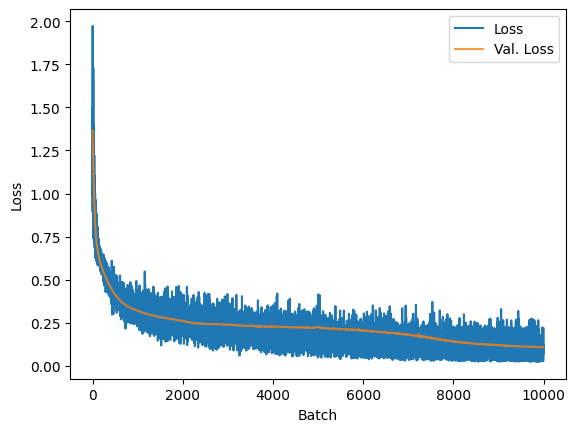

In [51]:
# Treinamento
losses = []
val_losses = []

x_val_pca = x_val_pca.to(device=device)
d_val_tensor = d_val_tensor.to(device=device)

for epoch in range(Ne):
  for n, (X, d) in enumerate(train_loader_pca):

    X = X.to(device=device)
    d = d.to(device=device)

    # Treinamento
    model_pca.train()
    model_pca.zero_grad()
    y = model_pca(X)
    loss = loss_function(y, d)
    loss.backward()
    optimizer.step()

    # Validação
    model_pca.eval()

    with torch.no_grad():
      y_val = model_pca(x_val_pca)
      val_loss = loss_function(y_val, d_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 and n == x_treino_pca.shape[0]//Nb - 1:
      print(f"Epoch: {epoch} | Loss: {loss} | Val. Loss: {val_loss}")

plt.figure()
plt.plot(losses)
plt.plot(val_losses, alpha=0.8)
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")


In [56]:
# Testando o modelo

# Converte os dados de teste em arrays numpy
# x_teste_np = data_test.iloc[:, :-1].to_numpy()
# d_teste_np = data_test.iloc[:, -1].to_numpy()

# Aplica a normalização no conjunto de teste
# x_teste_np_norm = (x_teste_np - media_treino) / desvio_padrao_treino

# Projeta o teste
x_teste_pca = (U @ x_teste_np_norm.T)
x_teste_pca = x_teste_pca.T

# Converte os arrays numpy em tensores PyTorch
x_teste_pca = torch.tensor(x_teste_pca, dtype=torch.float32).to(device=device)
d_teste_tensor = torch.tensor(d_teste_np, dtype=torch.long).to(device=device)

# Testa o modelo com os dados de teste
y_teste_tensor_pca = model_pca(x_teste_pca)
y_teste_np = y_teste_tensor_pca.cpu().detach().numpy()

predicoes_pca = np.argmax(y_teste_np, axis=1)
acuracia_pca = np.mean(predicoes_pca == d_teste_np)

# Taxa de erros

Taxa_de_erro_pca = (1 - acuracia_pca) * 100

print(f"Acurácia: {acuracia_pca*100:.2f}%")
print(f"Taxa de erro: {Taxa_de_erro_pca:.2f}%")

Acurácia: 95.11%
Taxa de erro: 4.89%


# Exercício 4

Repita os exercícios 1, 2 e 3, considerando a transformação dos dados usando o LDA no lugar do PCA. Use como referência o exemplo mostrado [neste Jupyter Notebook](./LDA_IRIS.ipynb)

## Resolução